In [46]:
using Revise
using TaD
using DifferentialEquations
using Zygote
#import Flux, DiffEqFlux
using Plots
using Optimisers
#import IJulia

# BSpline trajectory

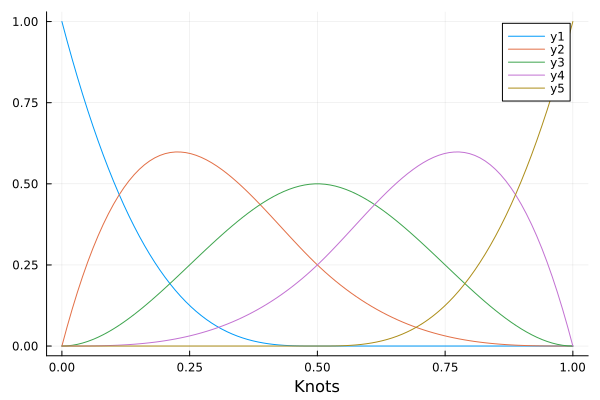

In [12]:
kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
basis = BSplineBasis(kv, 3, k=3)
plot(basis, k=0)

In [13]:
control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
c = BSplineCurve(basis, control_points)
c(1.0)

4×3 Matrix{Float64}:
  1.0   1.0   1.0
  4.5   4.5   0.6
 15.0  15.0   3.6
 25.8  25.8  11.4

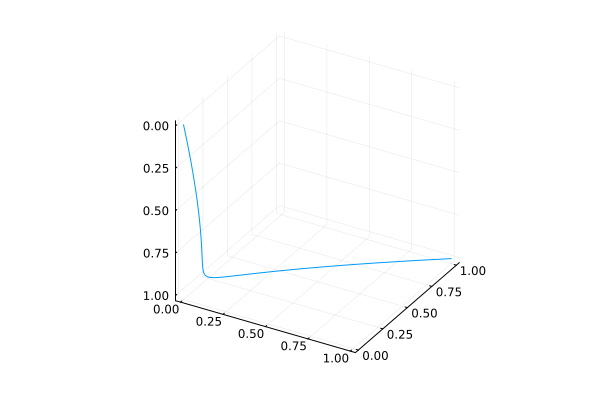

In [14]:
plot(c, zflip=true)

# Forward solution

For demonstration purposes, we'll be solving the soft string equation:

$$\frac{dF_t}{ds} = -w_{bp} \hat{t}_3 + \mu w_c,$$

where

$$w_{bp} = A g (\rho_p - \rho_m),$$

and

$$w_c = \sqrt{\left(F_t \kappa + w_{bp} \hat{n}_3\right)^2 + \left(w_{bp} \hat{b}_3 \right)^2}.$$

$\hat{t}, \hat{n}, \hat{b}$ are the tangential, normal, and bi-normal vectors in the Frenet frame that follows the drillstring trajectory.  From the position vector along trajectory curve defined by the B-Splines $\vec{r} = \vec{r}(s)$ these are defined as

$$\hat{t} = \frac{\vec{r}^\prime}{\left\Vert \vec{r}^\prime \right\Vert},$$

$$\hat{b} = \frac{\vec{r}^{\prime\prime}}{\left\Vert \vec{r}^{\prime\prime} \right\Vert},$$

$$\hat{n} = \hat{t} \times \hat{b},$$

and finally, $\kappa$ is the curvature defined by

$$\kappa = \frac{\left\Vert \vec{r}^{\prime} \times \vec{r}^{\prime\prime} \right\Vert}{\left\Vert \vec{r}^\prime \right\Vert^3}$$.

$\mu$ is the friction factor, $\rho_p$ and $\rho_m$ are the densities of the drill pipe and drilling mud respectively, $A$ is the cross-sectional area of the pipe, and $g$ is acceration due to gravity.

In [17]:
function parameterized_soft_string_drag1!(dF,F,p,s)
    kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
    basis = BSplineBasis(kv, 3, k=3)
    control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
    c = BSplineCurve(basis, control_points)
    
    p_ = [p[1], 0.1683, 0.09525, 9.81, 7800, 1298, c]
    soft_string_drag!(dF, F, p_, s)
end

parameterized_soft_string_drag1! (generic function with 1 method)

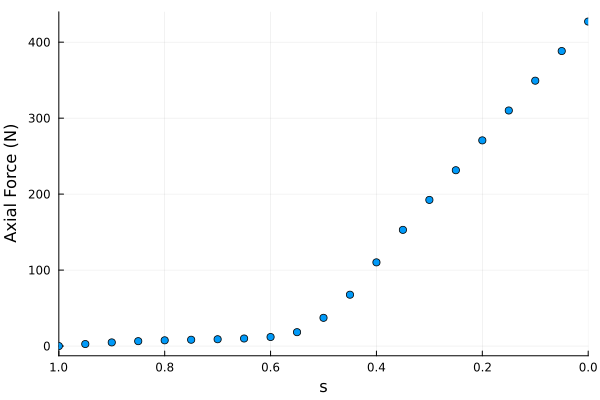

In [19]:
u0 = [0.0]
tspan = (1.0,0.0)
prob1 = ODEProblem(parameterized_soft_string_drag1!, u0, tspan, 0.2, saveat=0.05)
sol1 = solve(prob1)
scatter(sol1, xlabel="s", ylabel="Axial Force (N)", legend=false)

# Parameter estimation

The goal here is to solve the following minimization problem

$$\frac{\partial}{\partial \mu}\left(y_{data} - \int_{s_b}^0 \frac{dF_t(\mu, s)}{ds} ds\right)^2 = 0$$

In [83]:
function predict_tad1(μ)
  t = 0.0:0.1:1.0
  sol = solve(prob1,p=μ,saveat=0.05)(t).u
  getindex.(sol, 1)
end


loss1(μ, data) = sum(abs2, predict_tad1(μ[1]) - data) # loss function

loss1 (generic function with 3 methods)

In [81]:
# Generate "truth" data
data = predict_tad1(0.2) 

# Setup optimiser
opt = Optimisers.Adam(0.01)
st_opt = Optimisers.setup(opt, μ)

# Set number of training epochs
nepochs = 1000

# Training loop
for _ in 1:nepochs
    # Compute gradient
    gs = ForwardDiff.derivative(μ -> loss1(μ, data), μ[1]) 
    # Update μ
    st_opt, μ = Optimisers.update(st_opt, μ, gs)
    # Stop condition
    if loss1(μ, data) < 0.1
        break
    end
end

μ

1-element Vector{Float64}:
 0.20020566186479805

# SciML

First let's consider a spatially varying friction factor of the form

$$\mu(s) = 0.9 s^3 + 0.001$$

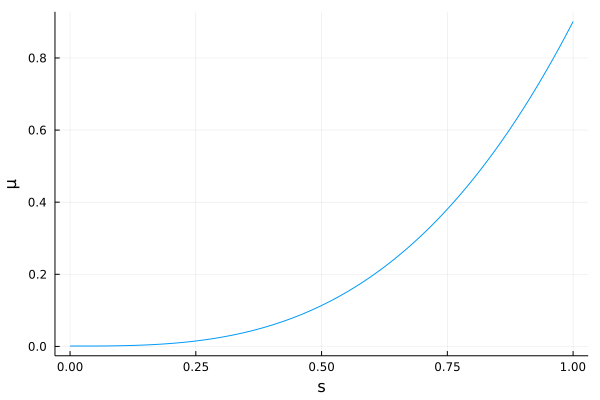

In [14]:
μf(x) = 0.9 * x ^ 3 + 0.001
plot(0:0.01:1, μf, xlabel="s", ylabel="μ",legend=false)

In [15]:
function parameterized_soft_string_drag2!(dF,F,p,s)
    kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
    basis = BSplineBasis(kv, 3, k=3)
    control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
    c = BSplineCurve(basis, control_points)
    p_ = [μf(s), 0.1683, 0.09525, 9.81, 7800, 1298, c]
    soft_string_drag(dF, F, p_, s)
end

parameterized_soft_string_drag2! (generic function with 1 method)

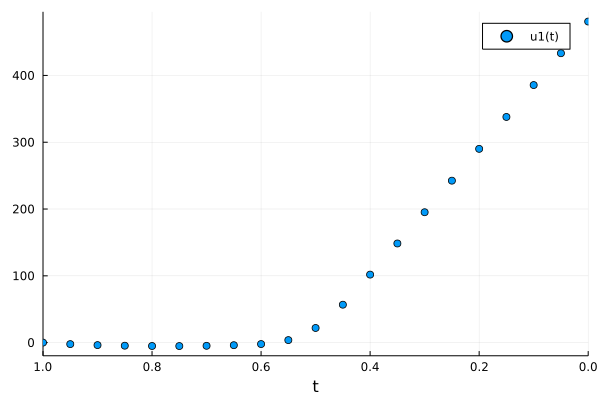

In [16]:
prob2 = ODEProblem(parameterized_soft_string_drag2!, u0, tspan, saveat=0.05)
sol2 = solve(prob2)
scatter(sol2)

The goal now is to solve the following minimization problem

$$\frac{\partial}{\partial \theta}\left(y_{data} - \int_{s_b}^0 \frac{dF_t\left(\mathcal{NN}_{\theta}(s)\right)}{ds} ds\right)^2 = 0$$

where $F_t$ is

$$\frac{dF_t}{ds} = -w_{bp} \hat{t}_3 + \mathcal{NN}_{\theta}(s) w_c,$$

In [17]:
m = Chain(
    Dense(1,6,tanh), 
    Dense(6,1,sigmoid) 
)

m = f64(m)
p, reU = Flux.destructure(m)
U(x, p) = reU(p)(x)

U (generic function with 1 method)

In [20]:
# p = [-0.9994877267896515
#  -0.34437658356060974
#  -1.3527229445305702
#  -0.8207319702900123
#   0.7521788183454649
#   1.3947347471990188
#  -0.5881658843511779
#   0.5428775362328541
#   0.7459662859144671
#   0.5401623652666937
#  -0.5679868194521287
#  -0.7334029148267974
#   0.8317052666603958
#  -1.0972775168768945
#  -2.0109095328590487
#  -1.8419695129692397
#   1.4774986802130194
#   1.4060984430046655
#  -0.3937010650434496];

In [18]:
function parameterized_soft_string_drag3!(dF,F,p,s)
    kv = [0, 0, 0, 0, 0.5, 1, 1, 1, 1]
    basis = BSplineBasis(kv, 3, k=3)
    control_points = [0.0 0.0 0.0; 0.1 0.1 0.75; 0.0 0.0 1.0; 0.25 0.25 0.9; 1.0 1.0 1.0]
    c = BSplineCurve(basis, control_points)
    p_ = [U([s],p)[1], 0.1683, 0.09525, 9.81, 7800, 1298, c]
    soft_string_drag(dF, F, p_, s)
end

prob3 = ODEProblem(parameterized_soft_string_drag3!, u0, tspan, p, saveat=0.05)

function predict_tad3(θ) # Our 1-layer "neural network"
  solve(prob3,p=θ,saveat=0.05)[1,:] # override with new parameters
end


loss3(θ) = sum(abs2,x-sol2[1,i] for (i,x) in enumerate(predict_tad3(θ)));

In [22]:
function cb2(θ,l) #callback function to observe training
  sleep(0.1)
  IJulia.clear_output(true)
  IJulia.display("Loss: $(l)")
  plot(0:0.1:1, μf, xlabel = "s", ylabel = "μ", label="μ(x)")
  IJulia.display(plot!(0:0.1:1, (x)-> U([x], θ)[1], label="NN(x)"))
  if l < 5.0
    return true 
  end
  return false 
end

cb2(p, loss3(p))
res1 = DiffEqFlux.sciml_train(loss3, p, ADAM(0.001), cb = cb2, maxiters=20000);

"Loss: 1.5807966380171719"

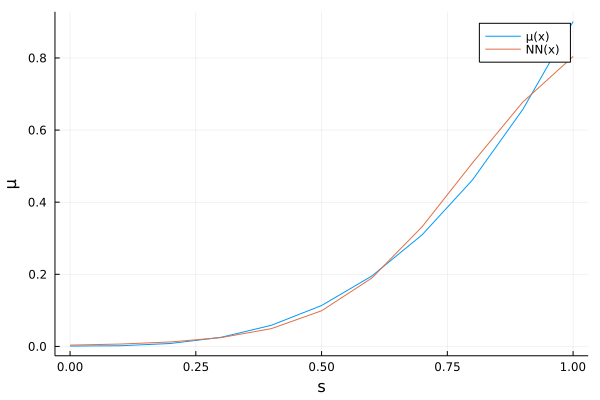

In [23]:
function cb3(θ,l) #callback function to observe training
  sleep(0.1)
  IJulia.clear_output(true)
  IJulia.display("Loss: $(l)")
  plot(0:0.1:1, μf, xlabel = "s", ylabel = "μ", label="μ(x)")
  IJulia.display(plot!(0:0.1:1, (x)-> U([x], θ)[1], label="NN(x)"))
  if l < 1.0
    return true 
  end
  return false 
end

cb3(p, loss3(p))
res2 = DiffEqFlux.sciml_train(loss3, res1.minimizer, BFGS(), cb=cb3, maxiters = 1000);

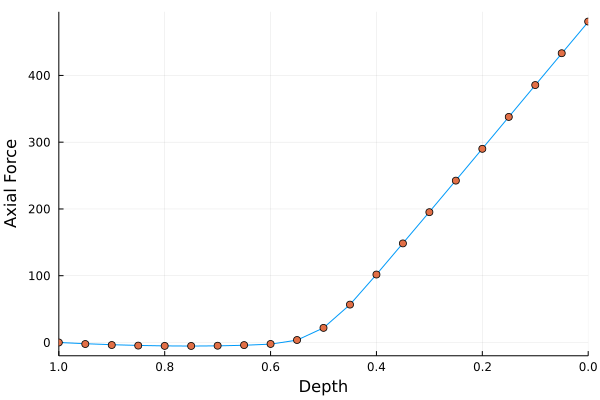

In [24]:
plot(1:-0.05:0.0, predict_tad3(res2.minimizer), xlabel="Depth", legend=false)
scatter!(sol2, xlabel="Depth", ylabel="Axial Force")

# Things to do

 * Trajectory reconstruction from survey data
 * Validate models
 * Train SciML models w/ real data